# 目次
## 1.Exploratory Data Analysis
## 2.欠損値と異常値の確認
## 3.説明変数として使えそうな値
## 4.データの前処理
## 5.線形回帰
## 6.決定木
## 7.ランダムフォレスト
## 8.アダブースト
## 9.クロスバリデーション（決定木）




## 1.Exploratory Data Analysis

In [1]:

#グラフをnotebook内に描画させるための設定
import pandas as pd
import pandas_profiling
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline 

from IPython.display import display
#https://pypi.org/project/pandas-profiling/1.4.0/
#使ってみる。

from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,recall_score,precision_score,classification_report
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV


### 実際のデータを読み込む

In [2]:
df_data = pd.read_csv("../1_data/survey.csv")
print(df_data.columns)
display(df_data.head())
display(df_data.tail())

Index(['Timestamp', 'Age', 'Gender', 'Country', 'state', 'self_employed',
       'family_history', 'treatment', 'work_interfere', 'no_employees',
       'remote_work', 'tech_company', 'benefits', 'care_options',
       'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'comments'],
      dtype='object')


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
1254,2015-09-12 11:17:21,26,male,United Kingdom,NaN,No,No,Yes,NaN,26-100,...,Somewhat easy,No,No,Some of them,Some of them,No,No,Don't know,No,NaN
1255,2015-09-26 01:07:35,32,Male,United States,IL,No,Yes,Yes,Often,26-100,...,Somewhat difficult,No,No,Some of them,Yes,No,No,Yes,No,NaN
1256,2015-11-07 12:36:58,34,male,United States,CA,No,Yes,Yes,Sometimes,More than 1000,...,Somewhat difficult,Yes,Yes,No,No,No,No,No,No,NaN
1257,2015-11-30 21:25:06,46,f,United States,NC,No,No,No,NaN,100-500,...,Don't know,Yes,No,No,No,No,No,No,No,NaN
1258,2016-02-01 23:04:31,25,Male,United States,IL,No,Yes,Yes,Sometimes,26-100,...,Don't know,Maybe,No,Some of them,No,No,No,Don't know,No,NaN


### ほとんどがカテゴリカルな値であり、まだ散布図等による分析は難しそう。まずは、データを見てみる。

In [3]:
# Pandas Profilingの実行
pandas_profiling.ProfileReport(df_data)

Number of variables,27
Number of observations,1259
Total Missing (%),5.6%
Total size in memory,265.6 KiB
Average record size in memory,216.1 B
Numeric,1
Categorical,26
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [4]:
df_data.isnull().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

### 2.欠損値と異常値の確認

    #### 2-1Timestamp
    特に、見直し不要。分析に利用する予定も無し。

    #### 2-2Age
    ありえない値を含んでいる。通常、働いている人の年齢は、18～80と考えられるので、それ以外のデータを取り除く。
    

In [5]:
record_len = len (df_data)
print('2-2Age削除前件数={0}'.format(record_len))

df_data = df_data[((df_data["Age"]  >= 18)  & (df_data["Age"]  < 80))]

record_len = len (df_data)
print('2-2Age削除後件数={0}'.format(record_len))


2-2Age削除前件数=1259
2-2Age削除後件数=1251


    #### 2-3Gender
    男性、女性、その他に分類した。

Male      977
Female    242
Other      32
Name: mapGender, dtype: int64

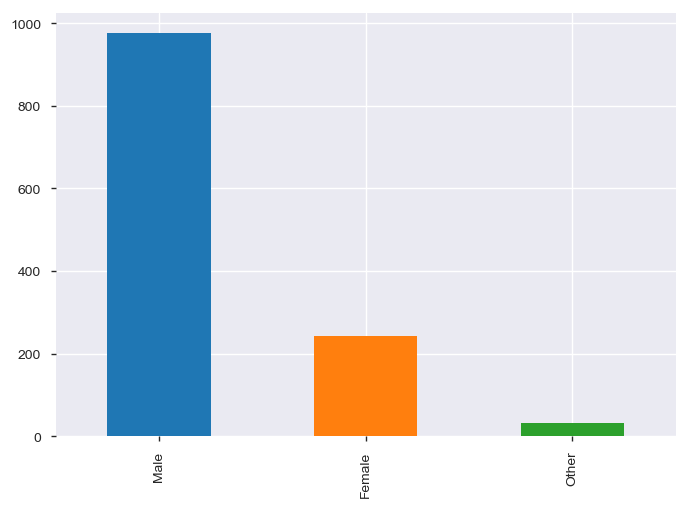

In [6]:
df_data["mapGender"] = df_data["Gender"].map({
    "Male":"Male",
    "male":"Male",
    "M": "Male",
    "m":"Male",
    "Make": "Male",
    "Male ": "Male",
    "Man": "Male",
    "Cis Male": "Male",
    "Female":"Female",
    "female": "Female",
    "F": "Female",
    "f": "Female",
    "Woman": "Female",
    "Female ": "Female",
    "woman": "Female"
})

df_data=df_data.fillna({"mapGender":"Other"})

display(df_data['mapGender'].value_counts())
df_data.head()
df_data['mapGender'].value_counts().plot(kind='bar')

    #### 2-4Country
    特に、見直し不要

    #### 2-5state
    特に、見直し不要。515件がNAであるが、United Statesに住んでいない人の回答は当然NAになるので、いったんこれで。

    #### 2-6self_employed
    NAが18件（1.4％程度）ある。これらは、"no_data"に置き換える。

In [7]:
df_data=df_data.fillna({"self_employed":"no_data"})

    #### 2-7family_history
    特に、見直し不要。

    #### 2-8treatment
    特に、見直し不要。

    #### 2-9work_interfere
    264件がNAである。これらは、"no_data"に置き換える。

In [8]:
df_data=df_data.fillna({"work_interfere":"no_data"})

    #### 2-10no_employees
    特に、見直し不要。

    #### 2-11remote_work
    特に、見直し不要

    #### 2-12tech_company
    特に、見直し不要

    #### 2-13benefits
    特に、見直し不要

    #### 2-14care_options
    特に、見直し不要

    #### 2-15wellness_program
    特に、見直し不要

    #### 2-16seek_help
    特に、見直し不要

    #### 2-17anonymity
    特に、見直し不要

    #### 2-18leave
    特に、見直し不要

    #### 2-19mental_health_consequence
    特に、見直し不要

    #### 2-20phys_health_consequence
    特に、見直し不要

    #### 2-21coworkers
    特に、見直し不要

    #### 2-22supervisor
    特に、見直し不要

    #### 2-23mental_health_interview
    特に、見直し不要

    #### 2-24phys_health_interview
    特に、見直し不要

    #### 2-25mental_vs_physical
    特に、見直し不要

    #### 2-26obs_consequence
    特に、見直し不要

    #### 2-27comments
    コメントを記入している人と、そうでない人とを分けてみる。

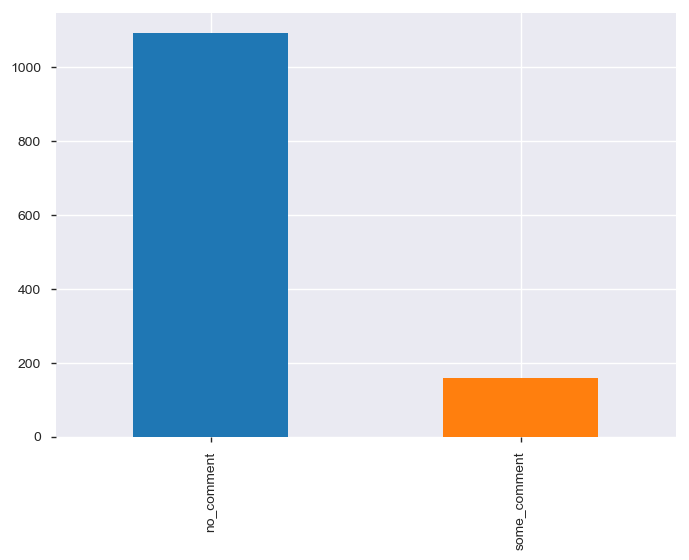

In [9]:


df_data=df_data.fillna({"comments":"no_comment"})


df_data["comments"] = df_data["comments"].replace({
    "-":"no_comment"
})

df_data["mapcomment"] = df_data["comments"].map({
    "no_comment":"no_comment"
})

df_data=df_data.fillna({"mapcomment":"some_comment"})
df_data['mapcomment'].value_counts().plot(kind='bar')

### 3.説明変数として使えそうな値

    #### 3-1Timestamp
    特に、使う予定無し。

    #### 3-2Age
    AgeとTreatmentとの関係を見てみる。結果、関係ありそう。少しTreatment Yesの人が、年齢が高そう。
    

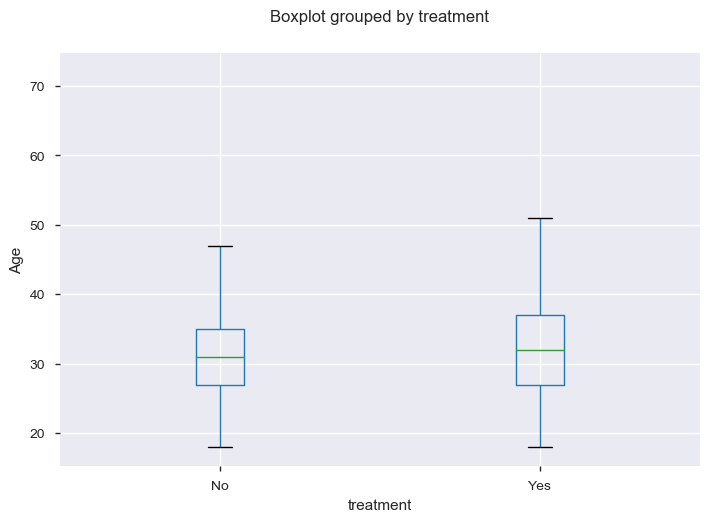

In [10]:
df_data.boxplot(column="Age",by="treatment")
plt.title("")
plt.ylabel("Age")
plt.show()


    #### 3-4Country
    CountryとTreatmentとの関係を見てみる。多少、United Statesの人の方が、Yesの割合が高いように見える。

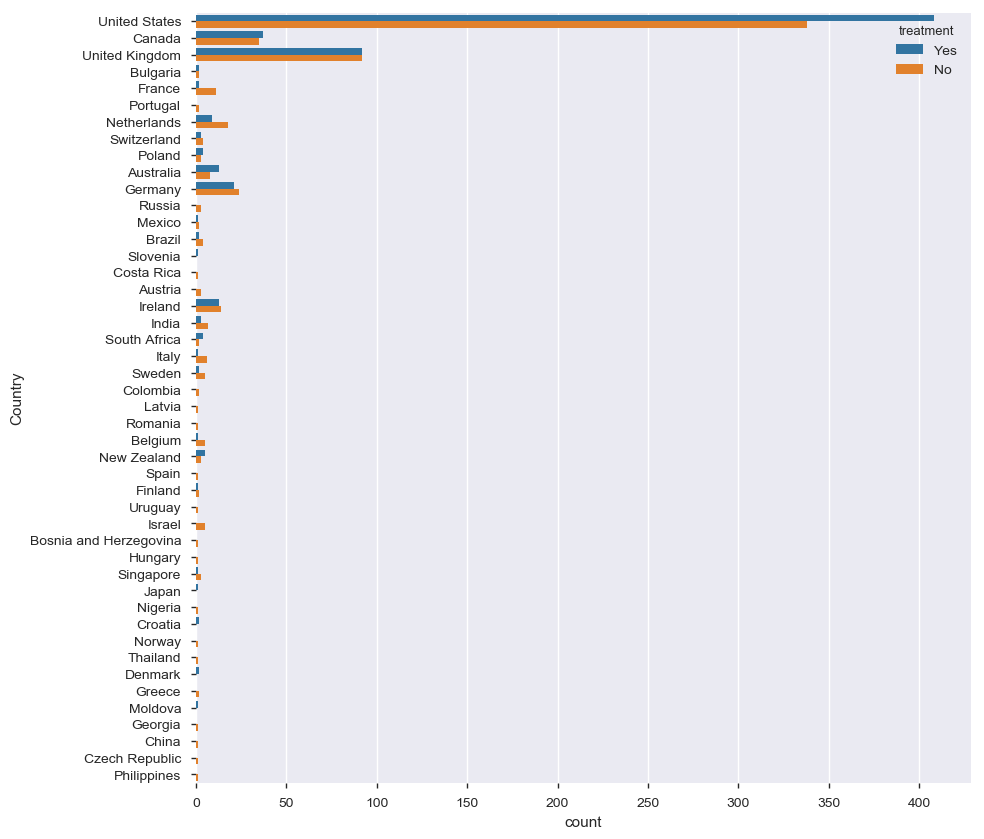

In [11]:
df=df_data[["Country","treatment"]]
plt.figure(figsize=(10, 10))
sns.countplot(y="Country", hue="treatment", hue_order=["Yes", "No"], data=df)
plt.show()
    


    #### 3-5state
    stateとtreatmentとの関係を見てみる。CAの人のtreatmentの割合は高いように見える。一方、TNの人のtreatmentは低い。stateによる影響はありそうに思う。

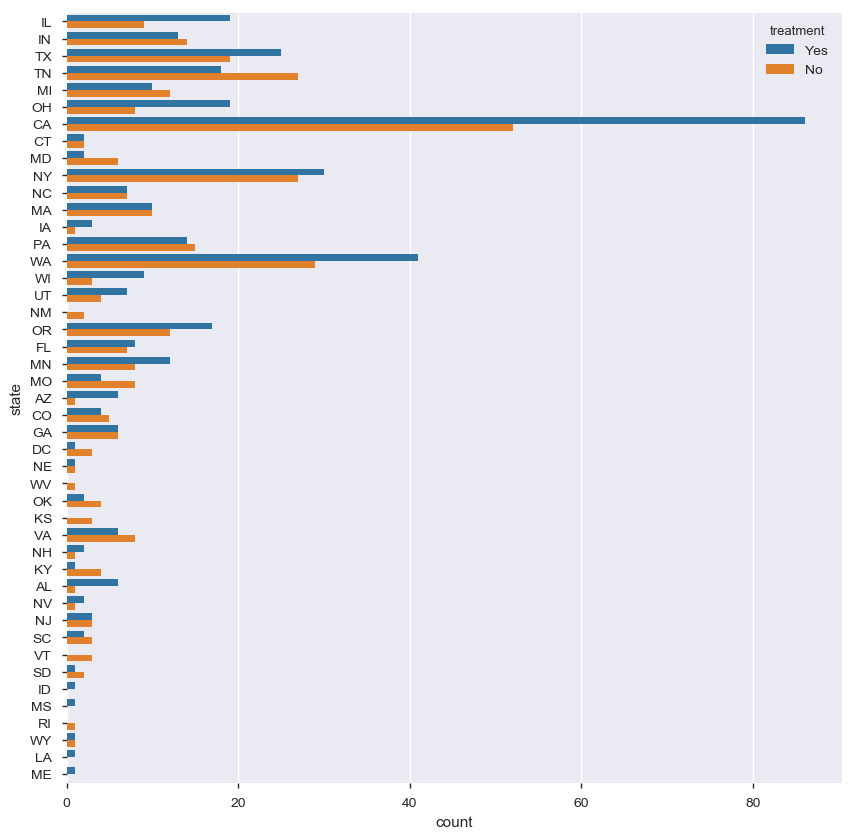

In [12]:
df=df_data[["state","treatment"]]
plt.figure(figsize=(10, 10))
sns.countplot(y="state", hue="treatment", hue_order=["Yes", "No"],data=df)
plt.show()

    #### 3-6self_employed
    少し、関係ありそう。Yesと答えた人の方が、treatment受けやすい。

self_employed


self_employed,No,Yes,no_data,All
treatment,,,,
No,543,67,9,619
Yes,548,75,9,632
All,1091,142,18,1251


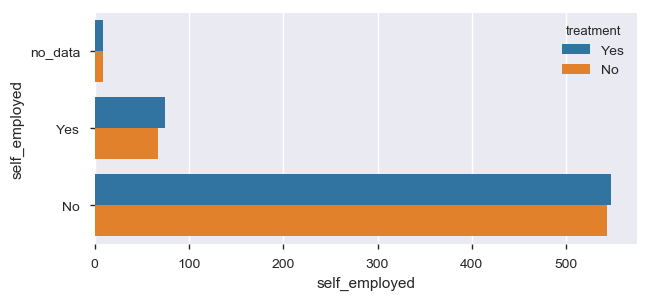

In [13]:
print("self_employed")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["self_employed"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="self_employed",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("self_employed")
plt.show()
print()

    #### 3-7family_history
    ばりばりに効いている。Yesと答えた人がtreatmentとなる割合は非常に高い。

family_history


family_history,No,Yes,All
treatment,,,
No,492,127,619
Yes,270,362,632
All,762,489,1251


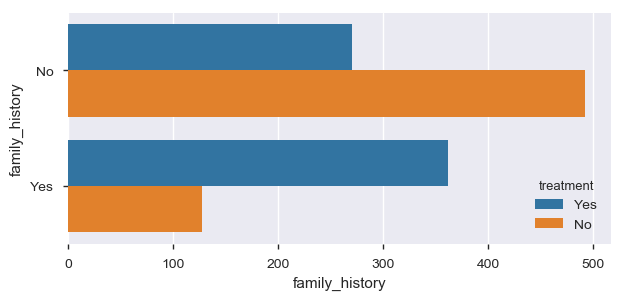

In [14]:
print("family_history")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["family_history"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="family_history",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("family_history")
plt.show()
print()

    #### 3-8treatment
    説明変数であり、特に何もしない。

    #### 3-9work_interfere
    かなり効いている。Oftenと答えた人がtreatmentを受ける割合が多い。
    また、"no_data"は、"Never"に分類できると推定されるので、おきかえする。

work_interfere


work_interfere,Never,Often,Rarely,Sometimes,no_data,All
treatment,,,,,,
No,182,21,51,107,258,619
Yes,30,119,122,357,4,632
All,212,140,173,464,262,1251


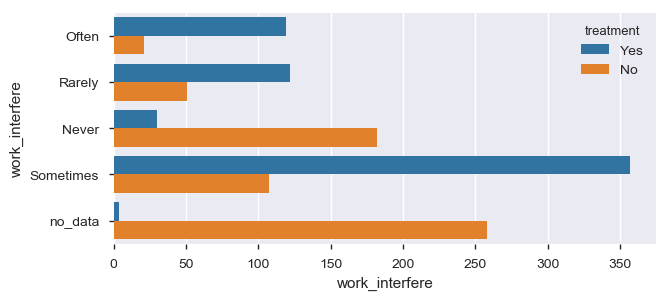

In [15]:
print("work_interfere")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["work_interfere"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="work_interfere",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("work_interfere")
plt.show()
print()

work_interfere_2


work_interfere,Never,Often,Rarely,Sometimes,All
treatment,,,,,
No,440,21,51,107,619
Yes,34,119,122,357,632
All,474,140,173,464,1251


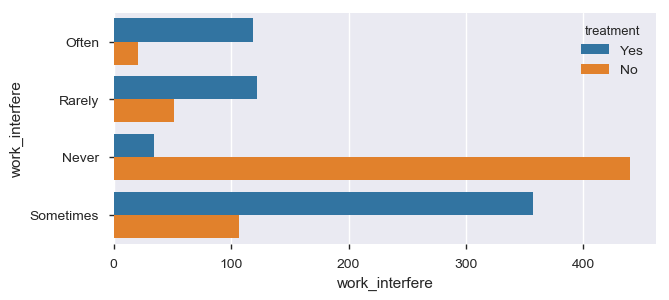

In [16]:
df_data["work_interfere"] = df_data["work_interfere"].replace({
    "no_data":"Never"
})

print("work_interfere_2")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["work_interfere"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="work_interfere",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("work_interfere")
plt.show()
print()


    #### 3-10no_employees
    少し、影響ありそう。1-5の会社と、26-100、100-500あたりが多そう。

no_employees


no_employees,1-5,100-500,26-100,500-1000,6-25,More than 1000,All
treatment,,,,,,,
No,70,80,139,33,162,135,619
Yes,88,95,149,27,127,146,632
All,158,175,288,60,289,281,1251


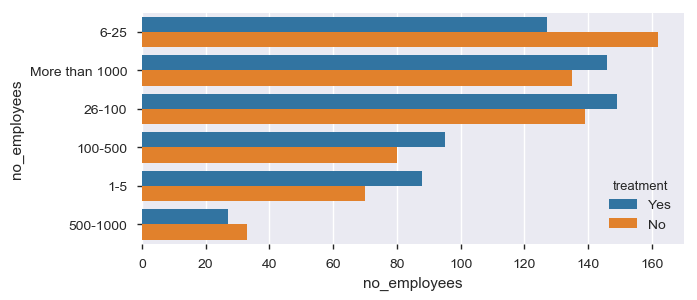

In [17]:
print("no_employees")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["no_employees"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="no_employees",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("no_employees")
plt.show()
print()

    #### 3-11remote_work
    少し関係ありそう。Yesの人の方が、treatment受けやすい。

remote_work


remote_work,No,Yes,All
treatment,,,
No,443,176,619
Yes,437,195,632
All,880,371,1251


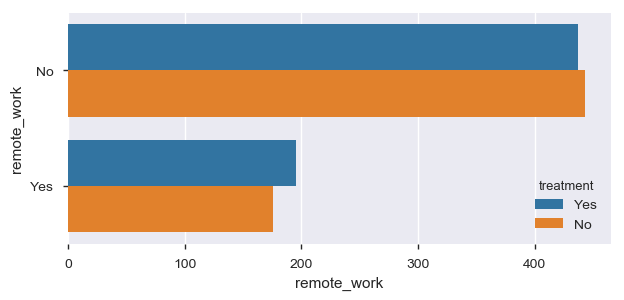

In [18]:
print("remote_work")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["remote_work"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="remote_work",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("remote_work")
plt.show()
print()

    #### 3-12tech_company
    少し関係ありそう。Noの方が、treatmentになりやすい。

tech_company


tech_company,No,Yes,All
treatment,,,
No,104,515,619
Yes,122,510,632
All,226,1025,1251


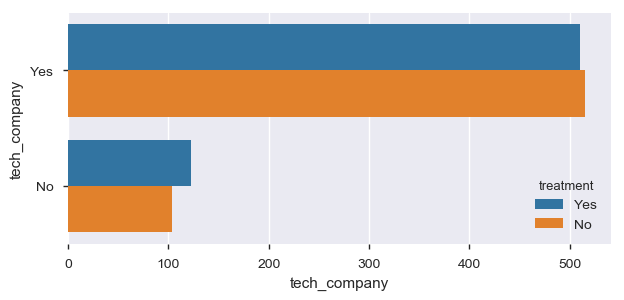

In [19]:
print("tech_company")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["tech_company"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="tech_company",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("tech_company")
plt.show()
print()

    #### 3-13benefits
    かなり効いている。Yesの人がtreatmentになりやすい。

benefits


benefits,Don't know,No,Yes,All
treatment,,,,
No,256,192,171,619
Yes,151,179,302,632
All,407,371,473,1251


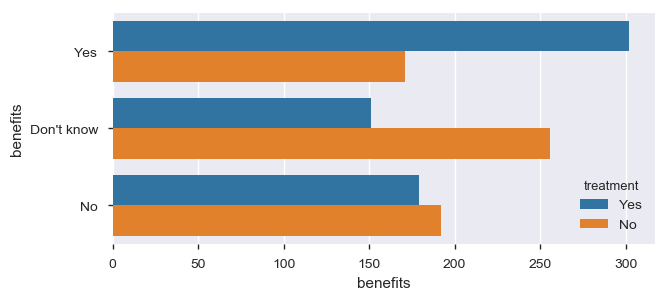

In [20]:
print("benefits")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["benefits"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="benefits",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("benefits")
plt.show()
print()

    #### 3-14care_options
    かなり効いている。Yesの人がtreatmentになりやすい。

care_options


care_options,No,Not sure,Yes,All
treatment,,,,
No,293,190,136,619
Yes,206,123,303,632
All,499,313,439,1251


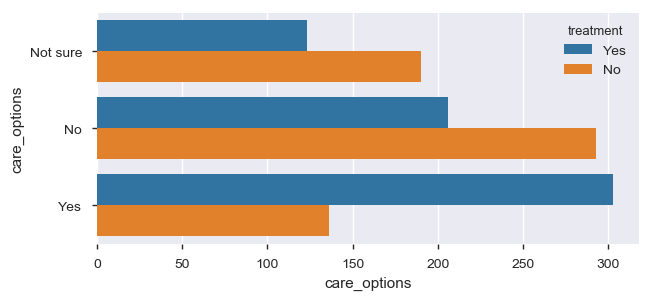

In [21]:
print("care_options")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["care_options"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="care_options",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("care_options")
plt.show()
print()

    #### 3-15wellness_program
    かなり効いている。Yesの人がtreatmentになりやすい。

wellness_program


wellness_program,Don't know,No,Yes,All
treatment,,,,
No,106,420,93,619
Yes,81,417,134,632
All,187,837,227,1251


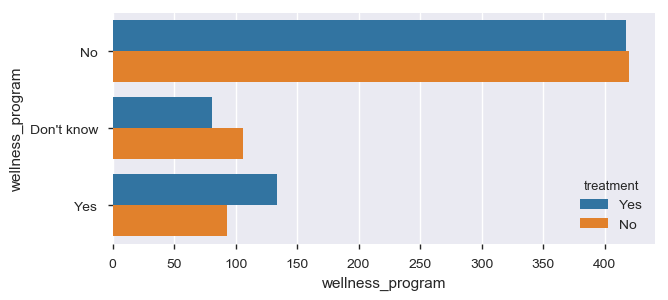

In [22]:
print("wellness_program")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["wellness_program"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="wellness_program",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("wellness_program")
plt.show()
print()

    #### 3-16seek_help
    かなり効いている。Yesの人がtreatmentになりやすい。

seek_help


seek_help,Don't know,No,Yes,All
treatment,,,,
No,197,321,101,619
Yes,166,320,146,632
All,363,641,247,1251


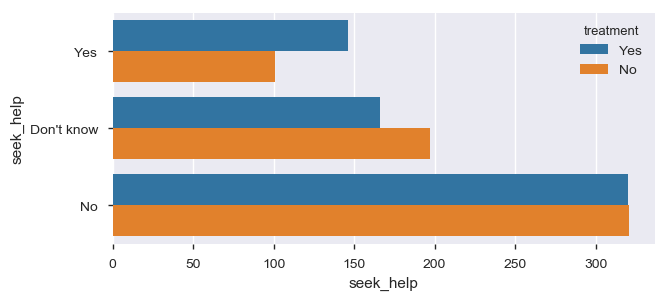

In [23]:
print("seek_help")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["seek_help"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="seek_help",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("seek_help")
plt.show()
print()

    #### 3-17anonymity
    かなり効いている。Yesの人がtreatmentになりやすい。

anonymity


anonymity,Don't know,No,Yes,All
treatment,,,,
No,446,27,146,619
Yes,369,37,226,632
All,815,64,372,1251


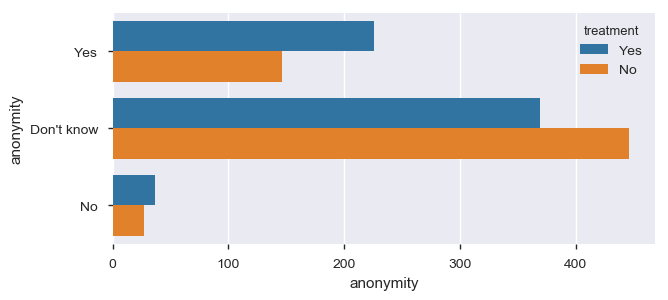

In [24]:
print("anonymity")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["anonymity"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="anonymity",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("anonymity")
plt.show()
print()

    #### 3-18leave
    効いている。難しいと感じている人ほどtreatmentを受けやすい。

leave


leave,Don't know,Somewhat difficult,Somewhat easy,Very difficult,Very easy,All
treatment,,,,,,
No,308,44,134,31,102,619
Yes,253,81,131,66,101,632
All,561,125,265,97,203,1251


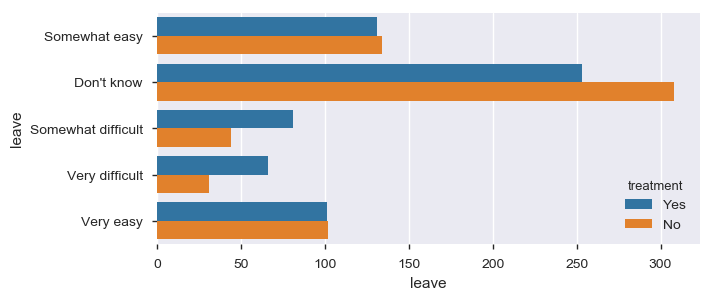

In [25]:
print("leave")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["leave"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="leave",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("leave")
plt.show()
print()

    #### 3-19mental_health_consequence
    効いている。悪影響があると感じている人ほどtreatmentを受けやすい。

mental_health_consequence


mental_health_consequence,Maybe,No,Yes,All
treatment,,,,
No,224,277,118,619
Yes,252,210,170,632
All,476,487,288,1251


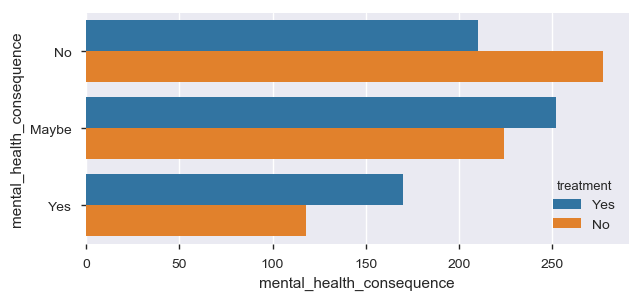

In [26]:
print("mental_health_consequence")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["mental_health_consequence"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="mental_health_consequence",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("mental_health_consequence")
plt.show()
print()

    #### 3-20phys_health_consequence
    少しだけ聞いている感じ。Yesと答えた人がtreatment受けやすい。

phys_health_consequence


phys_health_consequence,Maybe,No,Yes,All
treatment,,,,
No,127,467,25,619
Yes,146,453,33,632
All,273,920,58,1251


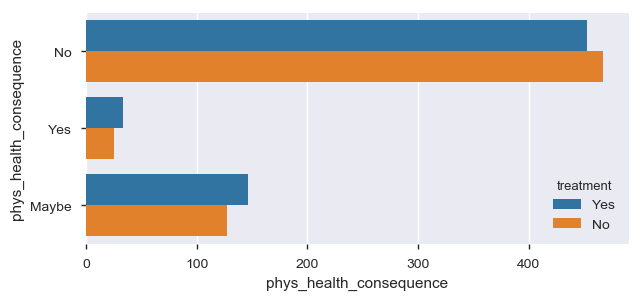

In [27]:
print("phys_health_consequence")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["phys_health_consequence"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="phys_health_consequence",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("phys_health_consequence")
plt.show()
print()

    #### 3-21coworkers
    少し効いている。Yesと答えた人の方がtreatment受けやすい。

coworkers


coworkers,No,Some of them,Yes,All
treatment,,,,
No,141,382,96,619
Yes,117,389,126,632
All,258,771,222,1251


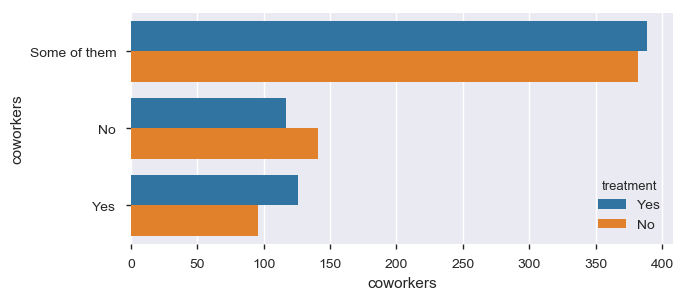

In [28]:
print("coworkers")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["coworkers"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="coworkers",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("coworkers")
plt.show()
print()

    #### 3-22supervisor
    少し効いている。Noと答えた人の方がtreatmentになりやすい

supervisor


supervisor,No,Some of them,Yes,All
treatment,,,,
No,186,169,264,619
Yes,204,180,248,632
All,390,349,512,1251


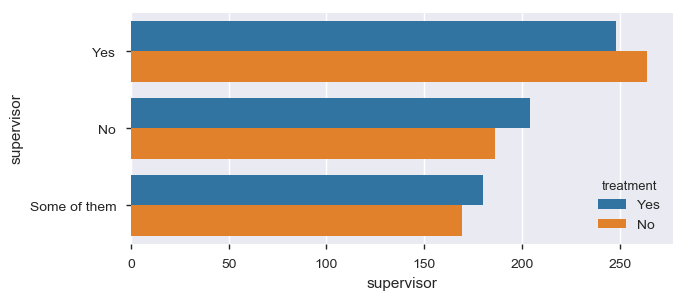

In [29]:
print("supervisor")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["supervisor"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="supervisor",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("supervisor")
plt.show()
print()

    #### 3-23mental_health_interview
    あまり、傾向ははっきり出ていないかな。

mental_health_interview


mental_health_interview,Maybe,No,Yes,All
treatment,,,,
No,125,476,18,619
Yes,82,527,23,632
All,207,1003,41,1251


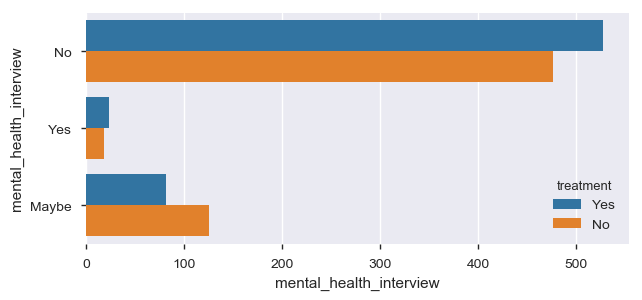

In [30]:
print("mental_health_interview")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["mental_health_interview"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="mental_health_interview",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("mental_health_interview")
plt.show()
print()

    #### 3-24phys_health_interview
    あまり、傾向ははっきり出ていないかな。

phys_health_interview


phys_health_interview,Maybe,No,Yes,All
treatment,,,,
No,289,239,91,619
Yes,266,257,109,632
All,555,496,200,1251


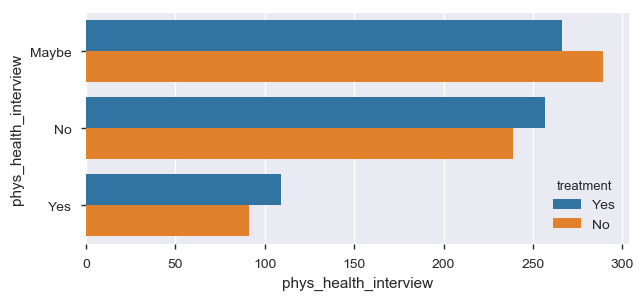

In [31]:
print("phys_health_interview")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["phys_health_interview"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="phys_health_interview",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("phys_health_interview")
plt.show()
print()

    #### 3-25mental_vs_physical
    それなりに効いている。Noと回答した人の方がtreatment受けやすい。

mental_vs_physical


mental_vs_physical,Don't know,No,Yes,All
treatment,,,,
No,315,138,166,619
Yes,259,200,173,632
All,574,338,339,1251


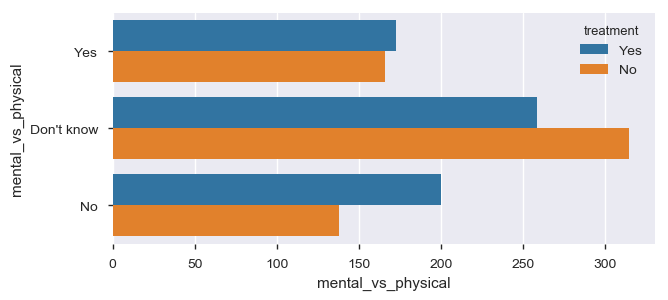

In [32]:
print("mental_vs_physical")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["mental_vs_physical"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="mental_vs_physical",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("mental_vs_physical")
plt.show()
print()

    #### 3-26obs_consequence
    かなり効いている。Yesと回答した人の方がtreatment受けやすい。

obs_consequence


obs_consequence,No,Yes,All
treatment,,,
No,563,56,619
Yes,507,125,632
All,1070,181,1251


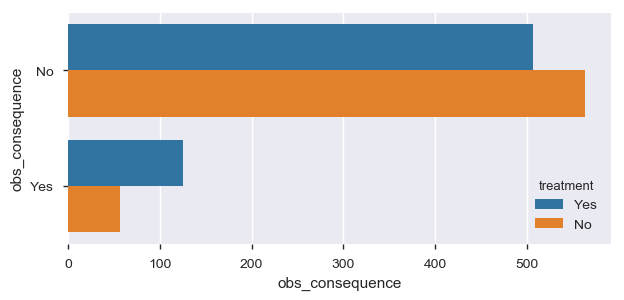

In [33]:
print("obs_consequence")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["obs_consequence"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="obs_consequence",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("obs_consequence")
plt.show()
print()

    #### 3-27comment
    効いている。コメントある人の方が、treatment受けやすい。

mapcomment


mapcomment,no_comment,some_comment,All
treatment,,,
No,563,56,619
Yes,528,104,632
All,1091,160,1251


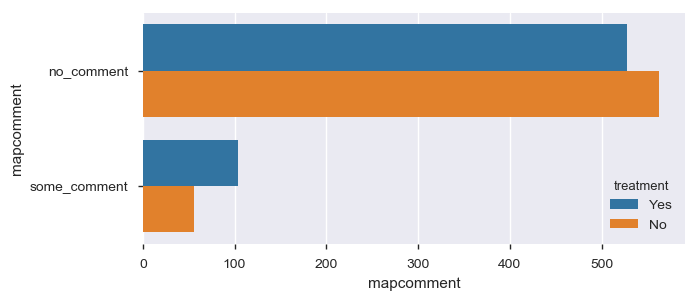

In [34]:
print("mapcomment")
df_c=pd.crosstab(index=df_data["treatment"],columns=df_data["mapcomment"],margins=True)
display(df_c)

plt.figure(figsize=(7,3))
sns.countplot(y="mapcomment",hue="treatment",hue_order=["Yes","No"],data=df_data)
plt.xlabel("mapcomment")
plt.show()
print()

## 4.データの前処理
前処理を行う。
・下記項目は使わない。
 "Timestamp"、"Gender"、"comments"
・下記"Yes"、"No"、"no_data"の3値の項目は、"1"、"0"で表現する。
　"treatment", "family_history", "remote_work", "tech_company", "obs_consequence",
・上記以外は、いったん、すべてダミー変数でやってみる。

In [35]:
df_data_c=df_data.drop("Timestamp",axis=1).drop("Gender",axis=1).drop("comments",axis=1)

col=df_data_c.columns.tolist()
col.remove('treatment')
col.insert(0,"treatment")
df_data_c=df_data_c.loc[:,col]

for column in df_data_c.columns:
    # YES/NOのデータの場合は、No:0, Yes:1 で置換する
    if column in ["treatment", "family_history", "remote_work", "tech_company", "obs_consequence", "mapcomment"]:
        df_data_c[column] = df_data_c[column].map({"No": 0, "Yes": 1, "no_comment": 0, "some_comment": 1})


#ダミー変数の生成
df_data_c=pd.get_dummies(df_data_c)

display(df_data_c.head())
display(df_data_c.shape)
df_data_c.to_csv(path_or_buf="df_data_c.csv")


,treatment,Age,family_history,remote_work,tech_company,obs_consequence,mapcomment,Country_Australia,Country_Austria,Country_Belgium,...,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,mapGender_Female,mapGender_Male,mapGender_Other
0,1,37,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
1,0,44,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
2,0,32,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,1,0
3,1,31,1,0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,0,31,0,1,1,0,0,0,0,0,...,1,0,0,1,1,0,0,0,1,0


(1251, 155)

相関係数が0.2以上と-0.2以下の項目を表示
正の相関


treatment                   1.000000
family_history              0.376674
work_interfere_Often        0.244812
work_interfere_Sometimes    0.405750
benefits_Yes                0.207857
care_options_Yes            0.272083
Name: treatment, dtype: float64

負の相関


work_interfere_Never   -0.677153
Name: treatment, dtype: float64

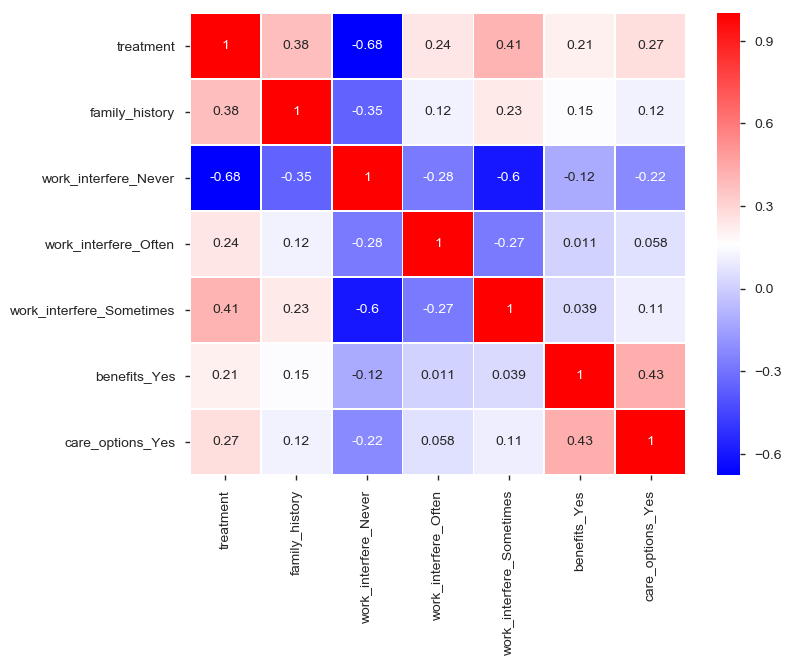

In [36]:
df_data_dummy_cc = pd.get_dummies(df_data_c).corr()
df_data_dummy_cc_treatment = df_data_dummy_cc["treatment"]

print("相関係数が0.2以上と-0.2以下の項目を表示")

# 相関係数が0.2以上, -0.2以下の値を取得する
target_cc_value = 0.2

print("正の相関")
display(df_data_dummy_cc_treatment[df_data_dummy_cc_treatment >= target_cc_value])
print("負の相関")
display(df_data_dummy_cc_treatment[df_data_dummy_cc_treatment <= (-1*target_cc_value)])



df_indexs = df_data_dummy_cc[(df_data_dummy_cc["treatment"] >= target_cc_value) | (df_data_dummy_cc["treatment"] <= (-1 * target_cc_value))].index

#print(df_data_dummy_cc)
df_cc_target=df_data_dummy_cc.loc[df_indexs,df_indexs]
plt.figure(figsize=(8, 6)) #heatmap size
sns.heatmap(df_cc_target, annot=True, cmap='bwr', linewidths=.5)
plt.show()


## 5.線形回帰

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# データを準備する
y = df_data_c["treatment"].values
X = df_data_c.iloc[:,1:].values
X_columns = df_data_c.iloc[:,1:].columns

#X_train = X
#y_train = y
X_train, X_test, y_train, y_test = train_test_split(X, y)




訓練のデータに対する識別率：57.95%


予測,0.0,1.0
実際,,
0,397,70
1,55,416


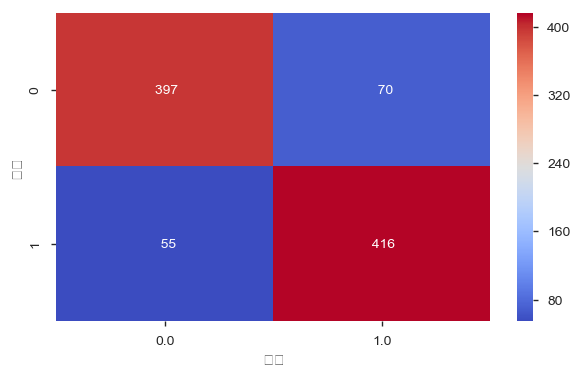

正解率：86.67%
再現率：88.32%
適合率：85.60%
F1：86.94%


In [38]:
# 最適パラメータを用いて識別する
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

score = regr.score(X_train, y_train) * 100
print('訓練のデータに対する識別率：{0:.2f}%'.format(score))

y_train_pred = regr.predict(X_train)
#print(y_train_pred)

# treatが0であるか、1であるかの閾値を指定できるようにしてみる。
threshhold=0.6

y_train_pred[y_train_pred > threshhold] =1
y_train_pred[y_train_pred <= threshhold] =0

df = pd.DataFrame({"実際":y_train,"予測":y_train_pred})  
df = df.groupby(["実際","予測"])[["予測"]].count()  
df.rename(columns={"予測":"num"},inplace=True)  
df.reset_index(inplace=True)  
df = df.pivot(index="実際",columns="予測",values="num")  

#線形回帰したときの値の分布を見てみる。
#plt.plot(y_test_pred.sort_values())


display(df)
plt.figure(figsize=(7, 4)) 
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='4d')
plt.show()

### Accuracy(正解率)の算出方法
accuracy = accuracy_score(y_train, y_train_pred)
### Recall(再現率)の算出方法
recall = recall_score(y_train, y_train_pred)
### Precision(適合率)の算出方法
precision = precision_score(y_train, y_train_pred)
### F1(再現率と適合率の調和平均)の算出方法
f1 = f1_score(y_train, y_train_pred)

print('正解率：{0:.2f}%'.format(accuracy * 100))
print('再現率：{0:.2f}%'.format(recall * 100))
print('適合率：{0:.2f}%'.format(precision * 100))
print('F1：{0:.2f}%'.format(f1 * 100))





予測,0.0,1.0
実際,,
0,121,31
1,29,132


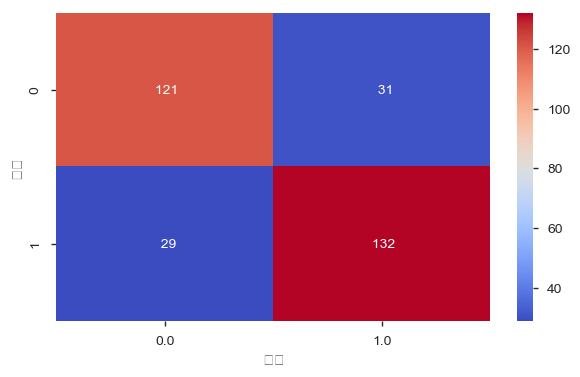

正解率：80.83%
再現率：81.99%
適合率：80.98%
F1：81.48%


In [39]:

##テストデータによる検証

y_test_pred = regr.predict(X_test)

# treatが0であるか、1であるかの閾値を指定できるようにする。

y_test_pred[y_test_pred > threshhold] =1
y_test_pred[y_test_pred <= threshhold] =0



df = pd.DataFrame({"実際":y_test,"予測":y_test_pred})  
df = df.groupby(["実際","予測"])[["予測"]].count()  
df.rename(columns={"予測":"num"},inplace=True)  
df.reset_index(inplace=True)  
df = df.pivot(index="実際",columns="予測",values="num")  


display(df)
plt.figure(figsize=(7, 4)) 
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='4d')
plt.show()

### Accuracy(正解率)の算出方法
accuracy = accuracy_score(y_test, y_test_pred)
### Recall(再現率)の算出方法
recall = recall_score(y_test, y_test_pred)
### Precision(適合率)の算出方法
precision = precision_score(y_test, y_test_pred)
### F1(再現率と適合率の調和平均)の算出方法
f1 = f1_score(y_test, y_test_pred)

print('正解率：{0:.2f}%'.format(accuracy * 100))
print('再現率：{0:.2f}%'.format(recall * 100))
print('適合率：{0:.2f}%'.format(precision * 100))
print('F1：{0:.2f}%'.format(f1 * 100))





In [40]:
#### threshholdによる　正解率の推移
##threshhold 正解率（訓練データ）　正解率（テストデータ）
##0          60.34%                63.58%
##0.1        71.64%                74.12%
##0.2        80.06%                82.11%
##0.3        82.84%                84.03%
##0.4        84.01%                84.03%
##0.5        85.61%                84.03%
##0.6        86.35%                85.30%
##0.7        81.88%                77.00%
##→threshhold（閾値）は0.6くらいが適当。



## 6.決定木

In [41]:

clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=1234)
clf = clf.fit(X_train, y_train)
print("train score=", clf.score(X_train, y_train))
print("test score=", clf.score(X_test, y_test))


train score= 0.9573560767590619
test score= 0.744408945686901


何か、オーバーフィットしている気がする。

,
work_interfere_Never,0.499240
Age,0.077582
phys_health_interview_Maybe,0.022913
family_history,0.022655
care_options_Yes,0.020641


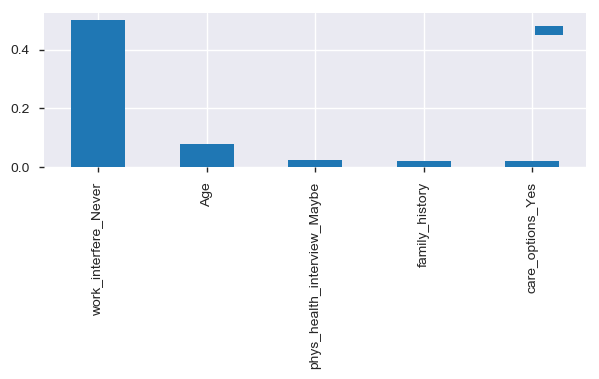

In [42]:
#各説明変数の重要度

df_result_score=pd.DataFrame(clf.feature_importances_, index=X_columns,columns=[""])
df_sort=df_result_score.sort_values(by=[""],ascending=False).head()
display(df_sort)
df_sort.plot.bar(figsize=(7,2))
plt.show()


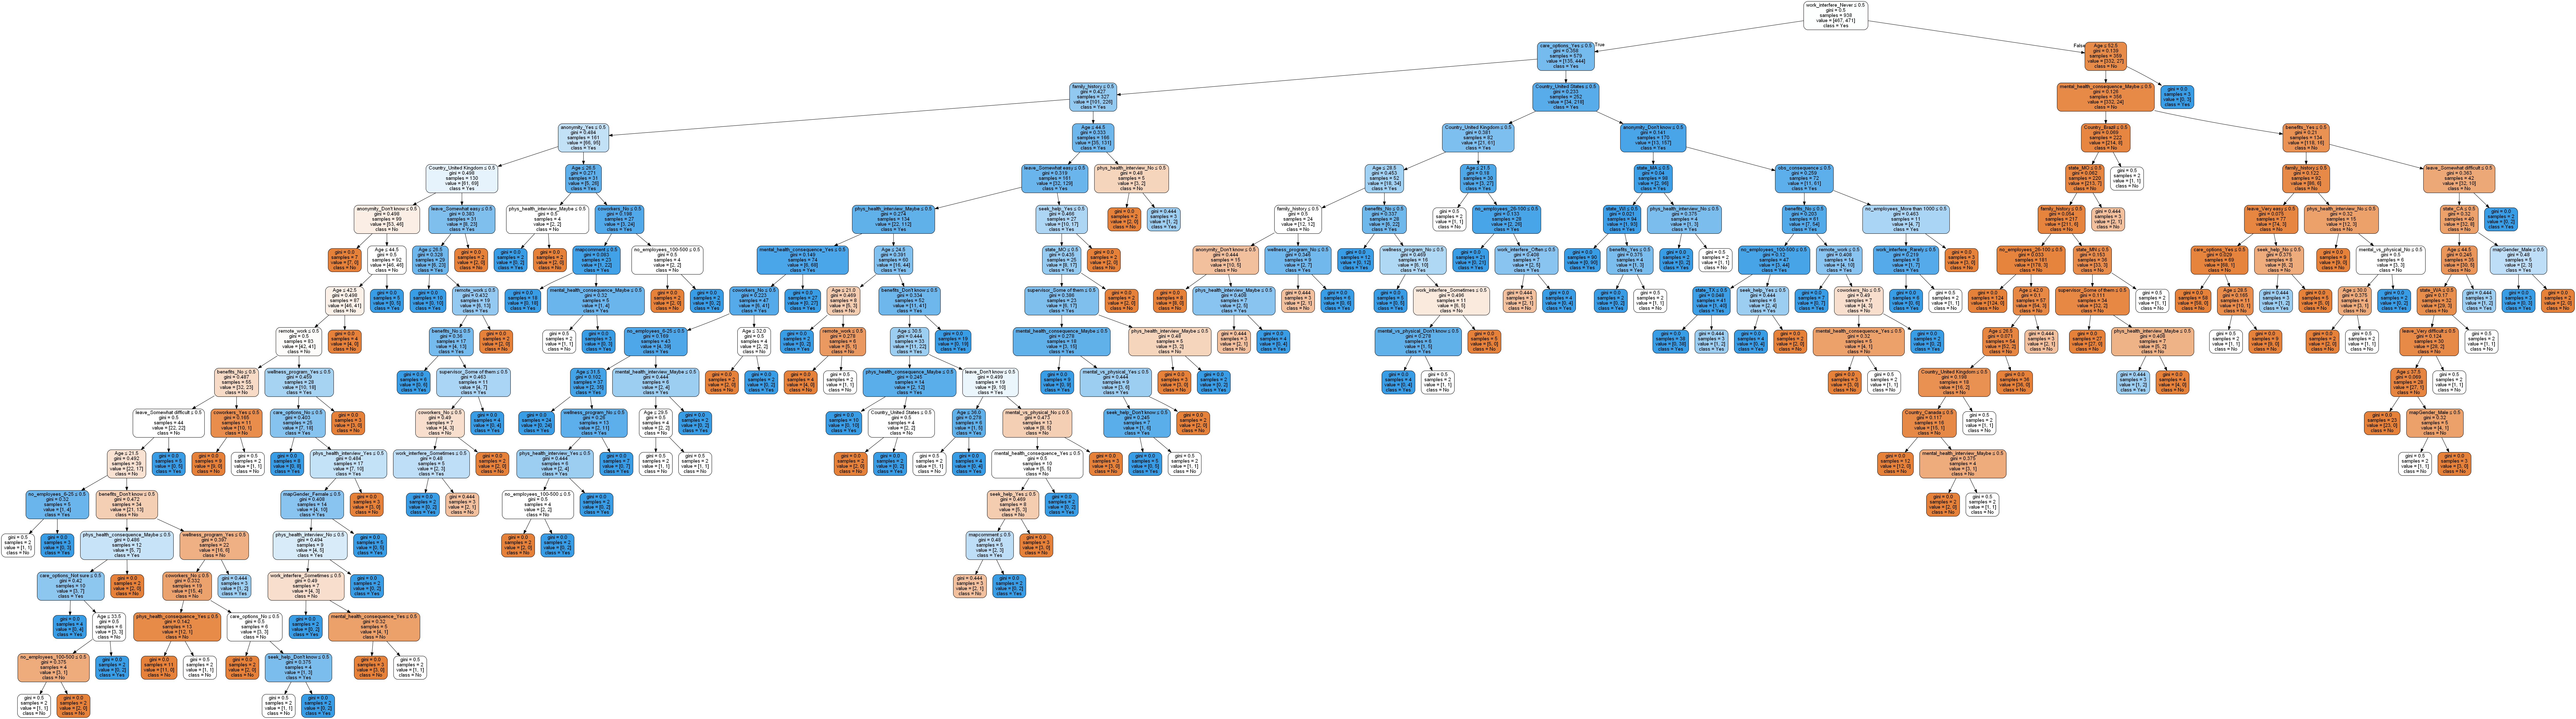

In [43]:
dot_data = StringIO()
export_graphviz(clf,out_file=dot_data,
               feature_names=X_columns,
               class_names=["No","Yes"],
               filled=True, rounded=True,
               special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

すごい決定木が出た。

## 7.ランダムフォレスト

In [44]:
clf = RandomForestClassifier(n_estimators=10, max_depth=2,criterion="gini",
                            min_samples_leaf=2,min_samples_split=2,random_state=1234)
clf.fit(X_train,y_train)
print("train score=",clf.score(X_train,y_train))
print("test score=",clf.score(X_test,y_test))



train score= 0.8049040511727079
test score= 0.8274760383386581


正解率
訓練データ：80％強
テストデータ：80％強
まずまずの正解率。

,
work_interfere_Sometimes,0.257060
work_interfere_Never,0.214600
family_history,0.140297
mapGender_Female,0.078958
state_TN,0.076923


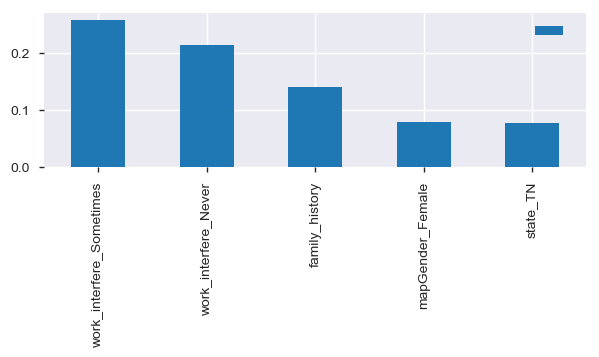

In [45]:
df_result_score=pd.DataFrame(clf.feature_importances_, index=X_columns,columns=[""])
df_sort=df_result_score.sort_values(by=[""],ascending=False).head()
display(df_sort)
df_sort.plot.bar(figsize=(7,2))
plt.show()

## 8.アダブースト

In [46]:
clf=AdaBoostClassifier(DecisionTreeClassifier(max_depth=3,
                                             min_samples_leaf=2,
                                             min_samples_split=2,
                                             random_state=1234,
                                             criterion="gini"),
                      n_estimators=10,random_state=1234)
clf.fit(X_train,y_train)
print("train score=",clf.score(X_train,y_train))
print("test score=",clf.score(X_test,y_test))


train score= 0.8901918976545842
test score= 0.7795527156549521


訓練用データに対するフィットが大きくなった。

## 9.クロスバリデーション（決定木）

In [47]:
param_grid = {'max_depth':[3,5,7,10],'min_samples_split':[2,3,5],'min_samples_leaf':[1,2,3,4,10,15]}
cv = GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,cv=5)
cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 2, 3, 4, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [48]:
cv.best_params_

{'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 2}

In [49]:
print(classification_report(y_test,cv.best_estimator_.predict(X_test)))

             precision    recall  f1-score   support

          0       0.81      0.81      0.81       152
          1       0.82      0.82      0.82       161

avg / total       0.81      0.81      0.81       313



In [50]:
print(confusion_matrix(y_test,cv.best_estimator_.predict(X_test)))

[[123  29]
 [ 29 132]]


今までの中では、一番正解率が高い。81％くらい。